In [1]:
# Experiment 2 (CNN LSTM as feature extractor) of feature extractor training with the CNNLSTM model model 3.
# CNN LSTM model is used as a feature extrator, SVM (ovo or ovr) and a single layer of LSTM is used as personlized classifier
# The personlized classifier is trained with 100% dataset
# The structure based on Guillaume Chevalier https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition
# The structure include read in of the input, formatting the input and the conversion of the one-hot encoding.
# The SVM is model is from sklearn library
# The CNN LSTM model and the feature extration method is written by myself
# The credit of this code goes to Guillaume Chevalier under MIT License.
# Python version 3.6

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0
from sklearn import metrics
import time
import os

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 

# Pathes to dataset
DATASET_PATH = "UCI HAR Dataset/"
TRAIN = "train/"
TEST = "test/"


def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]
y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

X_for_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
y_for_train = load_y(y_train_path)
y_test = load_y(y_test_path)

print("read in the data")

# randomly shuffle the array
def rand_shuffle_data(train_X, train_Y):
    item_size = np.array(train_X).shape
    sample_size = item_size[0]
    np.random.seed(42)
    value_list = np.arange(sample_size)
    np.random.shuffle(value_list)
    output_X = np.zeros(np.array(train_X).shape)
    output_Y = np.zeros(np.array(train_Y).shape)
    print(output_Y.shape)
    cnt = 0
    for idx in value_list:
        output_X[cnt,:,:] = train_X[idx,:,:]
        output_Y[cnt,:] = train_Y[idx,:]
        cnt += 1
    return value_list, output_X, output_Y

# The pre-trained model
def cnn_LSTM_net(_X, _weights, _biases):
    _X = tf.reshape(_X, [-1, n_steps, n_input]) 
    # convlution layers
    conv1 = tf.layers.separable_conv1d(_X, 32, 5, activation=tf.nn.relu, name='conv1_layer')
    conv1 = tf.layers.max_pooling1d(conv1, 20, 2, name='max1_layer')
    conv2 = tf.layers.separable_conv1d(conv1, 64, 5, activation=tf.nn.relu, name='conv2_layer')
    conv2 = tf.transpose(conv2, [1, 0, 2])
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.nn.dynamic_rnn(lstm_cells, conv2, dtype=tf.float32)
    lstm_last_output = outputs[-1]
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']

# The personlized model
def lstm_net(_X, _weights, _biases):
    conv2 = tf.transpose(_X, [1, 0, 2])
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.nn.dynamic_rnn(lstm_cells, conv2, dtype=tf.float32)
    lstm_last_output = outputs[-1]
    # Linear activation
    print(lstm_last_output.shape)
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']

def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS


percentage_list = [1]

for percent_train in percentage_list:
    
    tf.reset_default_graph() # reset my graph
    
    rand_shuffle_idx, train_X, train_y = rand_shuffle_data(X_for_train, y_for_train)
    pick_samples = int(round((np.array(X_for_train).shape[0])*percent_train))
    X_train = X_for_train[0:pick_samples, :, :]
    y_train = y_for_train[0:pick_samples,:]
    
    print(np.array(X_train).shape)
    
    # Input data and LSTM internal structure
    training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
    test_data_count = len(X_test)  # 2947 testing series
    n_height = 1
    n_steps = len(X_train[0])  # 128 timesteps per series
    n_input = len(X_train[0][0])
    n_hidden = 32
    n_classes = 6 # Total classes (should go up, or should go down)

    # Training parameters
    learning_rate = 0.0025
    lambda_loss_amount = 0.0015
    training_iters = training_data_count * 200  # Loop 200 times on the dataset
    batch_size = 1500
    display_iter = 300000  # To show test set accuracy during training
    
    # Graph input/output
    x = tf.placeholder(tf.float32, [None, n_steps, n_input])
    y = tf.placeholder(tf.float32, [None, n_classes])

    weights = {
        'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([n_classes]))
    }

    pred = cnn_LSTM_net(x,weights,biases)

    # Loss, optimizer and evaluation
    l2 = lambda_loss_amount * sum(
        tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
    ) # L2 loss prevents this overkill neural network to overfit the data
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2# Softmax loss
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # To keep track of training's performance
    test_losses = []
    test_accuracies = []
    train_losses = []
    train_accuracies = []

    # Launch the graph
    print("start training")
    start_time = time.time()
    sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
    init = tf.global_variables_initializer()
    sess.run(init)

    # Perform Training steps with "batch_size" amount of example data at each loop
    step = 1
    while step * batch_size <= training_iters:
        batch_xs =         extract_batch_size(X_train, step, batch_size)
        batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

        # Fit training using batch data
        _, loss, acc = sess.run(
            [optimizer, cost, accuracy],
            feed_dict={
                x: batch_xs, 
                y: batch_ys
            }
        )
        train_losses.append(loss)
        train_accuracies.append(acc)
        
        loss2, acc2 = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss2)
        test_accuracies.append(acc2)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):

            # To not spam console, show training accuracy/loss in this "if"
            print("Training iter #" + str(step*batch_size) + \
                  ":   Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))

            # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
            print("PERFORMANCE ON TEST SET: " + \
                  "Batch Loss = {}".format(loss2) + \
                  ", Accuracy = {}".format(acc2))

        step += 1

    print("Optimization Finished!")
    print("Training time is: " + str(time.time() - start_time) + " seconds")

    one_hot_predictions, accuracy, final_loss = sess.run(
        [pred, accuracy, cost],
        feed_dict={
            x: X_test,
            y: one_hot(y_test)
        }
    )

    print("FINAL RESULT: " + \
          "Batch Loss = {}".format(final_loss) + \
          ", Accuracy = {}".format(accuracy))

    
    # feature extration
    feature_tensor = sess.graph.get_tensor_by_name('conv2_layer/Relu:0')
    features = sess.run(feature_tensor, feed_dict={x:X_train})
    feature_shape = features.shape
    test_features = sess.run(feature_tensor,feed_dict={x:X_test})
    test_feature_shape = test_features.shape
    reformatted_features = np.zeros((feature_shape[0], feature_shape[1]*feature_shape[2]))
    test_reformatted_features = np.zeros((test_feature_shape[0], test_feature_shape[1]*test_feature_shape[2]))
    c = 0
    for row in features:
        reformatted_features[c,:] = row.flatten()
        c += 1
    d = 0
    for row in test_features:
        test_reformatted_features[d,:] = row.flatten()
        d += 1
    
    # classify with svm
    from sklearn.svm import SVC
    svm_starttime = time.time()
    clf = SVC()
    clf.fit(reformatted_features, y_train)
    print("-------------SVM(OVR)-------------")
    print("Training time is: " + str(time.time() - svm_starttime) + " seconds")
    print("FINAL SCORE FOR SVM OVR:")
    print(clf.score(test_reformatted_features, y_test))
    
    svm_pred_1 = clf.predict(test_reformatted_features)
    
    print("")
    print("Precision: {}%".format(100*metrics.precision_score(y_test, svm_pred_1, average="weighted")))
    print("Recall: {}%".format(100*metrics.recall_score(y_test, svm_pred_1, average="weighted")))
    print("f1_score: {}%".format(100*metrics.f1_score(y_test, svm_pred_1, average="weighted")))
    
    print("")
    print("Confusion Matrix:")
    confusion_matrix = metrics.confusion_matrix(y_test, svm_pred_1)
    print(confusion_matrix)
    normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

    print("")
    print("Confusion matrix (normalised to % of total test data):")
    print(normalised_confusion_matrix)
    print("Note: training and testing data is not equally distributed amongst classes, ")
    print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")
    
    # Plot Results: 
    width = 12
    height = 12
    f = plt.figure(figsize=(width, height))
    plt.imshow(
        normalised_confusion_matrix, 
        interpolation='nearest', 
        cmap=plt.cm.rainbow
    )
    plt.title("Confusion matrix \n(normalised to % of total test data)")
    plt.colorbar()
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, LABELS, rotation=90)
    plt.yticks(tick_marks, LABELS)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    f.savefig("cnnlstm_svm_ovr_conf.pdf", bbox_inches='tight')
    f.savefig("cnnlstm_svm_ovr_conf.png", bbox_inches='tight')
    
    
    svm2_starttime = time.time()
    clf2 = SVC(decision_function_shape='ovo')
    clf2.fit(reformatted_features, y_train)
    print("-------------SVM(OVO)-------------")
    print("Training time is: " + str(time.time() - svm2_starttime) + " seconds")
    print("FINAL SCORE FOR SVM OVR:")
    print(clf2.score(test_reformatted_features, y_test))
    
    svm_pred_2 = clf2.predict(test_reformatted_features)
    
    print("")
    print("Precision: {}%".format(100*metrics.precision_score(y_test, svm_pred_2, average="weighted")))
    print("Recall: {}%".format(100*metrics.recall_score(y_test, svm_pred_2, average="weighted")))
    print("f1_score: {}%".format(100*metrics.f1_score(y_test, svm_pred_2, average="weighted")))
    
    print("")
    print("Confusion Matrix:")
    confusion_matrix = metrics.confusion_matrix(y_test, svm_pred_2)
    print(confusion_matrix)
    normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

    print("")
    print("Confusion matrix (normalised to % of total test data):")
    print(normalised_confusion_matrix)
    print("Note: training and testing data is not equally distributed amongst classes, ")
    print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")
    
    # Plot Results: 
    width = 12
    height = 12
    f = plt.figure(figsize=(width, height))
    plt.imshow(
        normalised_confusion_matrix, 
        interpolation='nearest', 
        cmap=plt.cm.rainbow
    )
    plt.title("Confusion matrix \n(normalised to % of total test data)")
    plt.colorbar()
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, LABELS, rotation=90)
    plt.yticks(tick_marks, LABELS)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    f.savefig("cnnlstm_svm_ovo_conf.pdf", bbox_inches='tight')
    f.savefig("cnnlstm_svm_ovo_conf.png", bbox_inches='tight')
    
    start_time_lstm = time.time()
    print("-------------lstm-----------------")
    tf.reset_default_graph() # reset my graph
    
    learning_rate_lstm = 0.0025
    
    weights2 = {
        'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
    }
    biases2 = {
        'out': tf.Variable(tf.random_normal([n_classes]))
    }
    
    x_feat = tf.placeholder(tf.float32, [None, feature_shape[1], feature_shape[2]])
    y2 = tf.placeholder(tf.float32, [None, n_classes])
    pred_lstm = lstm_net(x_feat, weights2, biases2)
    cost2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y2, logits=pred_lstm))# Softmax loss
    optimizer2 = tf.train.AdamOptimizer(learning_rate=learning_rate_lstm).minimize(cost2)
    correct_pred2 = tf.equal(tf.argmax(pred_lstm,1), tf.argmax(y2,1))
    accuracy2 = tf.reduce_mean(tf.cast(correct_pred2, tf.float32))
    
    test_losses2 = []
    test_accuracies2 = []
    train_losses2 = []
    train_accuracies2 = []
    training_iters2 = training_data_count * 100  # Loop 100 times on the dataset
    
    sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
    init = tf.global_variables_initializer()
    sess.run(init)
    
    step = 1
    while step * batch_size <= training_iters2:
        batch_xxs =         extract_batch_size(features, step, batch_size)
        batch_yys = one_hot(extract_batch_size(y_train, step, batch_size))

        # Fit training using batch data
        _, loss, acc = sess.run(
            [optimizer2, cost2, accuracy2],
            feed_dict={
                x_feat: batch_xxs, 
                y2: batch_yys
            }
        )
        train_losses2.append(loss)
        train_accuracies2.append(acc)
        
        loss2, acc2 = sess.run(
            [cost2, accuracy2], 
            feed_dict={
                x_feat: test_features,
                y2: one_hot(y_test)
            }
        )
        test_losses2.append(loss2)
        test_accuracies2.append(acc2)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters2):

            # To not spam console, show training accuracy/loss in this "if"
            print("Training iter #" + str(step*batch_size) + \
                  ":   Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))

            # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
            print("PERFORMANCE ON TEST SET: " + \
                  "Batch Loss = {}".format(loss2) + \
                  ", Accuracy = {}".format(acc2))

        step += 1

    print("Optimization Finished!")
    print("Training time is: " + str(time.time() - start_time_lstm) + " seconds")

    one_hot_predictions2, accuracy2, final_loss2 = sess.run(
        [pred_lstm, accuracy2, cost2],
        feed_dict={
            x_feat: test_features,
            y2: one_hot(y_test)
        }
    )

    print("FINAL LSTM RESULT: " + \
          "Batch Loss = {}".format(final_loss2) + \
          ", Accuracy = {}".format(accuracy2))
    
    predictions2 = one_hot_predictions2.argmax(1)
    
    print("Testing Accuracy: {}%".format(100*accuracy2))

    print("")
    print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions2, average="weighted")))
    print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions2, average="weighted")))
    print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions2, average="weighted")))
    
    print("")
    print("Confusion Matrix:")
    confusion_matrix = metrics.confusion_matrix(y_test, predictions2)
    print(confusion_matrix)
    normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

    print("")
    print("Confusion matrix (normalised to % of total test data):")
    print(normalised_confusion_matrix)
    print("Note: training and testing data is not equally distributed amongst classes, ")
    print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")
    
    # Plot Results: 
    width = 12
    height = 12
    f = plt.figure(figsize=(width, height))
    plt.imshow(
        normalised_confusion_matrix, 
        interpolation='nearest', 
        cmap=plt.cm.rainbow
    )
    plt.title("Confusion matrix \n(normalised to % of total test data)")
    plt.colorbar()
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, LABELS, rotation=90)
    plt.yticks(tick_marks, LABELS)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    f.savefig("cnnlstm_feat_lstm_train_conf.pdf", bbox_inches='tight')
    f.savefig("cnnlstm_feat_lstm_train_conf.png", bbox_inches='tight')

read in the data
(7352, 1)
(7352, 128, 9)
Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

start training
Training iter #1500:   Batch Loss = 2.863983, Accuracy = 0.14533333480358124
PERFORMANCE ON TEST SET: Batch Loss = 2.720302104949951, Accuracy = 0.1425178200006485
Training iter #300000:   Batch Loss = 0.430425, Accuracy = 0.972000002861023
PERFORMANCE ON TEST SET: Batch Loss = 0.5676230192184448, Accuracy = 0.9267051219940186
Training iter #600000:   Batch Loss = 0.341473, Accuracy = 0.9753333330154419
PERFORMANCE ON TEST SET: Batch Loss = 0.5598466396331787, Accuracy = 0.9334917068481445
Training iter #900000:   Batch Loss = 0.258737, Accuracy = 0.9893333315849304
PERFORMANCE ON TEST SET: Batch Loss = 0.4117996394634247, Accuracy = 0.9501187801361084
Training iter #12000

c:\users\edwar\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-------------SVM(OVR)-------------
Training time is: 31.166205167770386 seconds
FINAL SCORE FOR SVM OVR:
0.8571428571428571

Precision: 85.67684044882586%
Recall: 85.71428571428571%
f1_score: 85.61955651967943%

Confusion Matrix:
[[443  21  32   0   0   0]
 [ 59 389  23   0   0   0]
 [ 31  15 374   0   0   0]
 [  0  17   0 347 121   6]
 [  0   2   0  94 436   0]
 [  0   0   0   0   0 537]]

Confusion matrix (normalised to % of total test data):
[[15.032236    0.7125891   1.08585     0.          0.          0.        ]
 [ 2.002036   13.199864    0.7804547   0.          0.          0.        ]
 [ 1.0519172   0.5089922  12.690872    0.          0.          0.        ]
 [ 0.          0.5768578   0.         11.774686    4.1058702   0.20359688]
 [ 0.          0.06786563  0.          3.1896844  14.794705    0.        ]
 [ 0.          0.          0.          0.          0.         18.22192   ]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that mo

<Figure size 1200x1200 with 2 Axes>

-------------SVM(OVO)-------------
Training time is: 31.257577896118164 seconds
FINAL SCORE FOR SVM OVR:
0.8571428571428571

Precision: 85.67684044882586%
Recall: 85.71428571428571%
f1_score: 85.61955651967943%

Confusion Matrix:
[[443  21  32   0   0   0]
 [ 59 389  23   0   0   0]
 [ 31  15 374   0   0   0]
 [  0  17   0 347 121   6]
 [  0   2   0  94 436   0]
 [  0   0   0   0   0 537]]

Confusion matrix (normalised to % of total test data):
[[15.032236    0.7125891   1.08585     0.          0.          0.        ]
 [ 2.002036   13.199864    0.7804547   0.          0.          0.        ]
 [ 1.0519172   0.5089922  12.690872    0.          0.          0.        ]
 [ 0.          0.5768578   0.         11.774686    4.1058702   0.20359688]
 [ 0.          0.06786563  0.          3.1896844  14.794705    0.        ]
 [ 0.          0.          0.          0.          0.         18.22192   ]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that mo

<Figure size 1200x1200 with 2 Axes>

-------------lstm-----------------
(?, 32)
Training iter #1500:   Batch Loss = 2.274322, Accuracy = 0.34200000762939453
PERFORMANCE ON TEST SET: Batch Loss = 1.7587647438049316, Accuracy = 0.30166271328926086
Training iter #300000:   Batch Loss = 0.024958, Accuracy = 0.996666669845581
PERFORMANCE ON TEST SET: Batch Loss = 0.18356430530548096, Accuracy = 0.9524940848350525
Training iter #600000:   Batch Loss = 0.060137, Accuracy = 0.9766666889190674
PERFORMANCE ON TEST SET: Batch Loss = 0.2611507177352905, Accuracy = 0.9501187801361084
Optimization Finished!
Training time is: 512.5083673000336 seconds
FINAL LSTM RESULT: Batch Loss = 0.24866531789302826, Accuracy = 0.9575839638710022
Testing Accuracy: 95.75839638710022%

Precision: 95.97518910756236%
Recall: 95.75839837122497%
f1_score: 95.77410410709045%

Confusion Matrix:
[[469   0  26   0   0   1]
 [  0 439  32   0   0   0]
 [  7   7 406   0   0   0]
 [  0  17   0 444  26   4]
 [  0   1   0   0 531   0]
 [  0   0   0   0   4 533]]

Co

<Figure size 1200x1200 with 2 Axes>

In [1]:
# Experiment 2 (CNN LSTM as feature extractor) of feature extractor training with the CNNLSTM model model 3.
# CNN LSTM model is used as a feature extrator, SVM (ovo or ovr) and a single layer of LSTM is used as personlized classifier
# The personlized classifier works on the 50% dataset
# The structure based on Guillaume Chevalier https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition
# The structure include read in of the input, formatting the input and the conversion of the one-hot encoding.
# The SVM is model is from sklearn library
# The CNN LSTM model and the feature extration method is written by myself
# The credit of this code goes to Guillaume Chevalier under MIT License.
# Python version 3.6

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0
from sklearn import metrics
import time
import os

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 

# Pathes to dataset
DATASET_PATH = "UCI HAR Dataset/"
TRAIN = "train/"
TEST = "test/"


def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]
y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

X_for_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
y_for_train = load_y(y_train_path)
y_test = load_y(y_test_path)

print("read in the data")

# randomly shuffle the array
def rand_shuffle_data(train_X, train_Y):
    item_size = np.array(train_X).shape
    sample_size = item_size[0]
    np.random.seed(42)
    value_list = np.arange(sample_size)
    np.random.shuffle(value_list)
    output_X = np.zeros(np.array(train_X).shape)
    output_Y = np.zeros(np.array(train_Y).shape)
    print(output_Y.shape)
    cnt = 0
    for idx in value_list:
        output_X[cnt,:,:] = train_X[idx,:,:]
        output_Y[cnt,:] = train_Y[idx,:]
        cnt += 1
    return value_list, output_X, output_Y

# The pre-trained model
def cnn_LSTM_net(_X, _weights, _biases):
    _X = tf.reshape(_X, [-1, n_steps, n_input]) 
    # convlution layers
    conv1 = tf.layers.separable_conv1d(_X, 32, 5, activation=tf.nn.relu, name='conv1_layer')
    conv1 = tf.layers.max_pooling1d(conv1, 20, 2, name='max1_layer')
    conv2 = tf.layers.separable_conv1d(conv1, 64, 5, activation=tf.nn.relu, name='conv2_layer')
    conv2 = tf.transpose(conv2, [1, 0, 2])
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.nn.dynamic_rnn(lstm_cells, conv2, dtype=tf.float32)
    lstm_last_output = outputs[-1]
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']

# The personlized model
def lstm_net(_X, _weights, _biases):
    conv2 = tf.transpose(_X, [1, 0, 2])
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.nn.dynamic_rnn(lstm_cells, conv2, dtype=tf.float32)
    lstm_last_output = outputs[-1]
    # Linear activation
    print(lstm_last_output.shape)
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']

def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS


percentage_list = [1]

for percent_train in percentage_list:
    
    tf.reset_default_graph() # reset my graph
    
    rand_shuffle_idx, train_X, train_y = rand_shuffle_data(X_for_train, y_for_train)
    pick_samples = int(round((np.array(X_for_train).shape[0])*percent_train))
    X_train = X_for_train[0:pick_samples, :, :]
    y_train = y_for_train[0:pick_samples,:]
    
    print(np.array(X_train).shape)
    
    # Input data and LSTM internal structure
    training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
    test_data_count = len(X_test)  # 2947 testing series
    n_height = 1
    n_steps = len(X_train[0])  # 128 timesteps per series
    n_input = len(X_train[0][0])
    n_hidden = 32
    n_classes = 6 # Total classes (should go up, or should go down)

    # Training parameters
    learning_rate = 0.0025
    lambda_loss_amount = 0.0015
    training_iters = training_data_count * 200  # Loop 200 times on the dataset
    batch_size = 1500
    display_iter = 300000  # To show test set accuracy during training
    
    # Graph input/output
    x = tf.placeholder(tf.float32, [None, n_steps, n_input])
    y = tf.placeholder(tf.float32, [None, n_classes])

    weights = {
        'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([n_classes]))
    }

    pred = cnn_LSTM_net(x,weights,biases)

    # Loss, optimizer and evaluation
    l2 = lambda_loss_amount * sum(
        tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
    ) # L2 loss prevents this overkill neural network to overfit the data
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2# Softmax loss
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # To keep track of training's performance
    test_losses = []
    test_accuracies = []
    train_losses = []
    train_accuracies = []

    # Launch the graph
    print("start training")
    start_time = time.time()
    sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
    init = tf.global_variables_initializer()
    sess.run(init)

    # Perform Training steps with "batch_size" amount of example data at each loop
    step = 1
    while step * batch_size <= training_iters:
        batch_xs =         extract_batch_size(X_train, step, batch_size)
        batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

        # Fit training using batch data
        _, loss, acc = sess.run(
            [optimizer, cost, accuracy],
            feed_dict={
                x: batch_xs, 
                y: batch_ys
            }
        )
        train_losses.append(loss)
        train_accuracies.append(acc)
        
        loss2, acc2 = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss2)
        test_accuracies.append(acc2)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):

            # To not spam console, show training accuracy/loss in this "if"
            print("Training iter #" + str(step*batch_size) + \
                  ":   Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))

            # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
            print("PERFORMANCE ON TEST SET: " + \
                  "Batch Loss = {}".format(loss2) + \
                  ", Accuracy = {}".format(acc2))

        step += 1

    print("Optimization Finished!")
    print("Training time is: " + str(time.time() - start_time) + " seconds")

    one_hot_predictions, accuracy, final_loss = sess.run(
        [pred, accuracy, cost],
        feed_dict={
            x: X_test,
            y: one_hot(y_test)
        }
    )

    print("FINAL RESULT: " + \
          "Batch Loss = {}".format(final_loss) + \
          ", Accuracy = {}".format(accuracy))

    
    pick_samples_1 = int(round((np.array(X_for_train).shape[0])*0.5))
    X_train_1 = X_for_train[0:pick_samples_1, :, :]
    y_train_1 = y_for_train[0:pick_samples_1,:]
    
    # feature extration
    feature_tensor = sess.graph.get_tensor_by_name('conv2_layer/Relu:0')
    features = sess.run(feature_tensor, feed_dict={x:X_train_1})
    feature_shape = features.shape
    test_features = sess.run(feature_tensor,feed_dict={x:X_test})
    test_feature_shape = test_features.shape
    reformatted_features = np.zeros((feature_shape[0], feature_shape[1]*feature_shape[2]))
    test_reformatted_features = np.zeros((test_feature_shape[0], test_feature_shape[1]*test_feature_shape[2]))
    c = 0
    for row in features:
        reformatted_features[c,:] = row.flatten()
        c += 1
    d = 0
    for row in test_features:
        test_reformatted_features[d,:] = row.flatten()
        d += 1
    
    # classify with svm
    from sklearn.svm import SVC
    svm_starttime = time.time()
    clf = SVC()
    clf.fit(reformatted_features, y_train_1)
    print("-------------SVM(OVR)-------------")
    print("Training time is: " + str(time.time() - svm_starttime) + " seconds")
    print("FINAL SCORE FOR SVM OVR:")
    print(clf.score(test_reformatted_features, y_test))
    
    svm_pred_1 = clf.predict(test_reformatted_features)
    
    print("")
    print("Precision: {}%".format(100*metrics.precision_score(y_test, svm_pred_1, average="weighted")))
    print("Recall: {}%".format(100*metrics.recall_score(y_test, svm_pred_1, average="weighted")))
    print("f1_score: {}%".format(100*metrics.f1_score(y_test, svm_pred_1, average="weighted")))
    
    print("")
    print("Confusion Matrix:")
    confusion_matrix = metrics.confusion_matrix(y_test, svm_pred_1)
    print(confusion_matrix)
    normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

    print("")
    print("Confusion matrix (normalised to % of total test data):")
    print(normalised_confusion_matrix)
    print("Note: training and testing data is not equally distributed amongst classes, ")
    print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")
    
    # Plot Results: 
    width = 12
    height = 12
    f = plt.figure(figsize=(width, height))
    plt.imshow(
        normalised_confusion_matrix, 
        interpolation='nearest', 
        cmap=plt.cm.rainbow
    )
    plt.title("Confusion matrix \n(normalised to % of total test data)")
    plt.colorbar()
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, LABELS, rotation=90)
    plt.yticks(tick_marks, LABELS)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    f.savefig("cnnlstm_svm_ovr_conf1.pdf", bbox_inches='tight')
    f.savefig("cnnlstm_svm_ovr_conf1.png", bbox_inches='tight')
    
    
    svm2_starttime = time.time()
    clf2 = SVC(decision_function_shape='ovo')
    clf2.fit(reformatted_features, y_train_1)
    print("-------------SVM(OVO)-------------")
    print("Training time is: " + str(time.time() - svm2_starttime) + " seconds")
    print("FINAL SCORE FOR SVM OVR:")
    print(clf2.score(test_reformatted_features, y_test))
    
    svm_pred_2 = clf2.predict(test_reformatted_features)
    
    print("")
    print("Precision: {}%".format(100*metrics.precision_score(y_test, svm_pred_2, average="weighted")))
    print("Recall: {}%".format(100*metrics.recall_score(y_test, svm_pred_2, average="weighted")))
    print("f1_score: {}%".format(100*metrics.f1_score(y_test, svm_pred_2, average="weighted")))
    
    print("")
    print("Confusion Matrix:")
    confusion_matrix = metrics.confusion_matrix(y_test, svm_pred_2)
    print(confusion_matrix)
    normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

    print("")
    print("Confusion matrix (normalised to % of total test data):")
    print(normalised_confusion_matrix)
    print("Note: training and testing data is not equally distributed amongst classes, ")
    print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")
    
    # Plot Results: 
    width = 12
    height = 12
    f = plt.figure(figsize=(width, height))
    plt.imshow(
        normalised_confusion_matrix, 
        interpolation='nearest', 
        cmap=plt.cm.rainbow
    )
    plt.title("Confusion matrix \n(normalised to % of total test data)")
    plt.colorbar()
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, LABELS, rotation=90)
    plt.yticks(tick_marks, LABELS)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    f.savefig("cnnlstm_svm_ovo_conf1.pdf", bbox_inches='tight')
    f.savefig("cnnlstm_svm_ovo_conf1.png", bbox_inches='tight')
    
    start_time_lstm = time.time()
    print("-------------lstm-----------------")
    tf.reset_default_graph() # reset my graph
    
    learning_rate_lstm = 0.0025
    
    weights2 = {
        'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
    }
    biases2 = {
        'out': tf.Variable(tf.random_normal([n_classes]))
    }
    
    x_feat = tf.placeholder(tf.float32, [None, feature_shape[1], feature_shape[2]])
    y2 = tf.placeholder(tf.float32, [None, n_classes])
    pred_lstm = lstm_net(x_feat, weights2, biases2)
    cost2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y2, logits=pred_lstm))# Softmax loss
    optimizer2 = tf.train.AdamOptimizer(learning_rate=learning_rate_lstm).minimize(cost2)
    correct_pred2 = tf.equal(tf.argmax(pred_lstm,1), tf.argmax(y2,1))
    accuracy2 = tf.reduce_mean(tf.cast(correct_pred2, tf.float32))
    
    test_losses2 = []
    test_accuracies2 = []
    train_losses2 = []
    train_accuracies2 = []
    training_iters2 = training_data_count * 100  # Loop 100 times on the dataset
    
    sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
    init = tf.global_variables_initializer()
    sess.run(init)
    
    step = 1
    while step * batch_size <= training_iters2:
        batch_xxs =         extract_batch_size(features, step, batch_size)
        batch_yys = one_hot(extract_batch_size(y_train_1, step, batch_size))

        # Fit training using batch data
        _, loss, acc = sess.run(
            [optimizer2, cost2, accuracy2],
            feed_dict={
                x_feat: batch_xxs, 
                y2: batch_yys
            }
        )
        train_losses2.append(loss)
        train_accuracies2.append(acc)
        
        loss2, acc2 = sess.run(
            [cost2, accuracy2], 
            feed_dict={
                x_feat: test_features,
                y2: one_hot(y_test)
            }
        )
        test_losses2.append(loss2)
        test_accuracies2.append(acc2)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters2):

            # To not spam console, show training accuracy/loss in this "if"
            print("Training iter #" + str(step*batch_size) + \
                  ":   Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))

            # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
            print("PERFORMANCE ON TEST SET: " + \
                  "Batch Loss = {}".format(loss2) + \
                  ", Accuracy = {}".format(acc2))

        step += 1

    print("Optimization Finished!")
    print("Training time is: " + str(time.time() - start_time_lstm) + " seconds")

    one_hot_predictions2, accuracy2, final_loss2 = sess.run(
        [pred_lstm, accuracy2, cost2],
        feed_dict={
            x_feat: test_features,
            y2: one_hot(y_test)
        }
    )

    print("FINAL LSTM RESULT: " + \
          "Batch Loss = {}".format(final_loss2) + \
          ", Accuracy = {}".format(accuracy2))
    
    predictions2 = one_hot_predictions2.argmax(1)
    
    print("Testing Accuracy: {}%".format(100*accuracy2))

    print("")
    print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions2, average="weighted")))
    print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions2, average="weighted")))
    print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions2, average="weighted")))
    
    print("")
    print("Confusion Matrix:")
    confusion_matrix = metrics.confusion_matrix(y_test, predictions2)
    print(confusion_matrix)
    normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

    print("")
    print("Confusion matrix (normalised to % of total test data):")
    print(normalised_confusion_matrix)
    print("Note: training and testing data is not equally distributed amongst classes, ")
    print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")
    
    # Plot Results: 
    width = 12
    height = 12
    f = plt.figure(figsize=(width, height))
    plt.imshow(
        normalised_confusion_matrix, 
        interpolation='nearest', 
        cmap=plt.cm.rainbow
    )
    plt.title("Confusion matrix \n(normalised to % of total test data)")
    plt.colorbar()
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, LABELS, rotation=90)
    plt.yticks(tick_marks, LABELS)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    f.savefig("cnnlstm_feat_lstm_train_conf1.pdf", bbox_inches='tight')
    f.savefig("cnnlstm_feat_lstm_train_conf1.png", bbox_inches='tight')

read in the data
(7352, 1)
(7352, 128, 9)
Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

start training
Training iter #1500:   Batch Loss = 2.586469, Accuracy = 0.14533333480358124
PERFORMANCE ON TEST SET: Batch Loss = 2.5635905265808105, Accuracy = 0.1425178200006485
Training iter #300000:   Batch Loss = 0.392232, Accuracy = 0.9779999852180481
PERFORMANCE ON TEST SET: Batch Loss = 0.5255632996559143, Accuracy = 0.9311164021492004
Training iter #600000:   Batch Loss = 0.314711, Accuracy = 0.9806666374206543
PERFORMANCE ON TEST SET: Batch Loss = 0.42468589544296265, Accuracy = 0.9423142075538635
Training iter #900000:   Batch Loss = 0.222358, Accuracy = 0.996666669845581
PERFORMANCE ON TEST SET: Batch Loss = 0.3646925687789917, Accuracy = 0.9470648169517517
Training iter #120

c:\users\edwar\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-------------SVM(OVR)-------------
Training time is: 9.784814596176147 seconds
FINAL SCORE FOR SVM OVR:
0.8445877163216831

Precision: 84.94110903225469%
Recall: 84.45877163216831%
f1_score: 84.5084431983994%

Confusion Matrix:
[[473   4  19   0   0   0]
 [ 56 397  18   0   0   0]
 [ 41  44 335   0   0   0]
 [  0   0   0 351 140   0]
 [  0   0   0 108 424   0]
 [  0   1   0   0  27 509]]

Confusion matrix (normalised to % of total test data):
[[16.05022     0.13573125  0.6447235   0.          0.          0.        ]
 [ 1.9002376  13.471326    0.6107906   0.          0.          0.        ]
 [ 1.3912454   1.4930438  11.367493    0.          0.          0.        ]
 [ 0.          0.          0.         11.910418    4.7505937   0.        ]
 [ 0.          0.          0.          3.664744   14.387512    0.        ]
 [ 0.          0.03393281  0.          0.          0.916186   17.271801  ]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more

<Figure size 1200x1200 with 2 Axes>

-------------SVM(OVO)-------------
Training time is: 9.791866779327393 seconds
FINAL SCORE FOR SVM OVR:
0.8445877163216831

Precision: 84.94110903225469%
Recall: 84.45877163216831%
f1_score: 84.5084431983994%

Confusion Matrix:
[[473   4  19   0   0   0]
 [ 56 397  18   0   0   0]
 [ 41  44 335   0   0   0]
 [  0   0   0 351 140   0]
 [  0   0   0 108 424   0]
 [  0   1   0   0  27 509]]

Confusion matrix (normalised to % of total test data):
[[16.05022     0.13573125  0.6447235   0.          0.          0.        ]
 [ 1.9002376  13.471326    0.6107906   0.          0.          0.        ]
 [ 1.3912454   1.4930438  11.367493    0.          0.          0.        ]
 [ 0.          0.          0.         11.910418    4.7505937   0.        ]
 [ 0.          0.          0.          3.664744   14.387512    0.        ]
 [ 0.          0.03393281  0.          0.          0.916186   17.271801  ]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that more

<Figure size 1200x1200 with 2 Axes>

-------------lstm-----------------
(?, 32)
Training iter #1500:   Batch Loss = 2.907452, Accuracy = 0.30266666412353516
PERFORMANCE ON TEST SET: Batch Loss = 2.131521701812744, Accuracy = 0.34747201204299927
Training iter #300000:   Batch Loss = 0.011924, Accuracy = 0.9993333220481873
PERFORMANCE ON TEST SET: Batch Loss = 0.23089906573295593, Accuracy = 0.9446895122528076
Training iter #600000:   Batch Loss = 0.019851, Accuracy = 0.9933333396911621
PERFORMANCE ON TEST SET: Batch Loss = 0.27710995078086853, Accuracy = 0.9429928660392761
Optimization Finished!
Training time is: 500.97373962402344 seconds
FINAL LSTM RESULT: Batch Loss = 0.2707633972167969, Accuracy = 0.9487614631652832
Testing Accuracy: 94.87614631652832%

Precision: 95.19054266963273%
Recall: 94.87614523243977%
f1_score: 94.91503334948601%

Confusion Matrix:
[[466   0  30   0   0   0]
 [  0 450  15   0   6   0]
 [  5  10 405   0   0   0]
 [  0   0   0 455  36   0]
 [  0   1   0   5 526   0]
 [ 15   0   0   1  27 494]]

C

<Figure size 1200x1200 with 2 Axes>

read in the data
(7352, 1)
(7352, 128, 9)
start training
Training iter #1500:   Batch Loss = 3.004152, Accuracy = 0.23066666722297668
PERFORMANCE ON TEST SET: Batch Loss = 2.982813835144043, Accuracy = 0.21750932931900024
Training iter #300000:   Batch Loss = 0.878896, Accuracy = 0.9293333292007446
PERFORMANCE ON TEST SET: Batch Loss = 1.0750219821929932, Accuracy = 0.8062436580657959
Training iter #600000:   Batch Loss = 0.557821, Accuracy = 0.8573333621025085
PERFORMANCE ON TEST SET: Batch Loss = 0.661785900592804, Accuracy = 0.8581608533859253
Training iter #900000:   Batch Loss = 0.330677, Accuracy = 0.9526666402816772
PERFORMANCE ON TEST SET: Batch Loss = 0.5054173469543457, Accuracy = 0.8808958530426025
Training iter #1200000:   Batch Loss = 0.278224, Accuracy = 0.9539999961853027
PERFORMANCE ON TEST SET: Batch Loss = 0.4370726943016052, Accuracy = 0.8893790245056152
Training iter #1500000:   Batch Loss = 0.310223, Accuracy = 0.9393333196640015
PERFORMANCE ON TEST SET: Batch Loss

c:\users\edwar\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-------------SVM(OVR)-------------
Training time is: 189.09908866882324 seconds
FINAL SCORE FOR SVM OVR:
0.5873769935527655

Precision: 65.33044800918265%
Recall: 58.737699355276554%
f1_score: 49.75906649475647%

Confusion Matrix:
[[493   0   3   0   0   0]
 [471   0   0   0   0   0]
 [247   0 173   0   0   0]
 [  0   0   0  23 468   0]
 [  0   0   0   0 532   0]
 [  3  24   0   0   0 510]]

Confusion matrix (normalised to % of total test data):
[[16.728876    0.          0.10179844  0.          0.          0.        ]
 [15.982355    0.          0.          0.          0.          0.        ]
 [ 8.381405    0.          5.8703766   0.          0.          0.        ]
 [ 0.          0.          0.          0.7804547  15.880556    0.        ]
 [ 0.          0.          0.          0.         18.052256    0.        ]
 [ 0.10179844  0.8143875   0.          0.          0.         17.305735  ]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that m

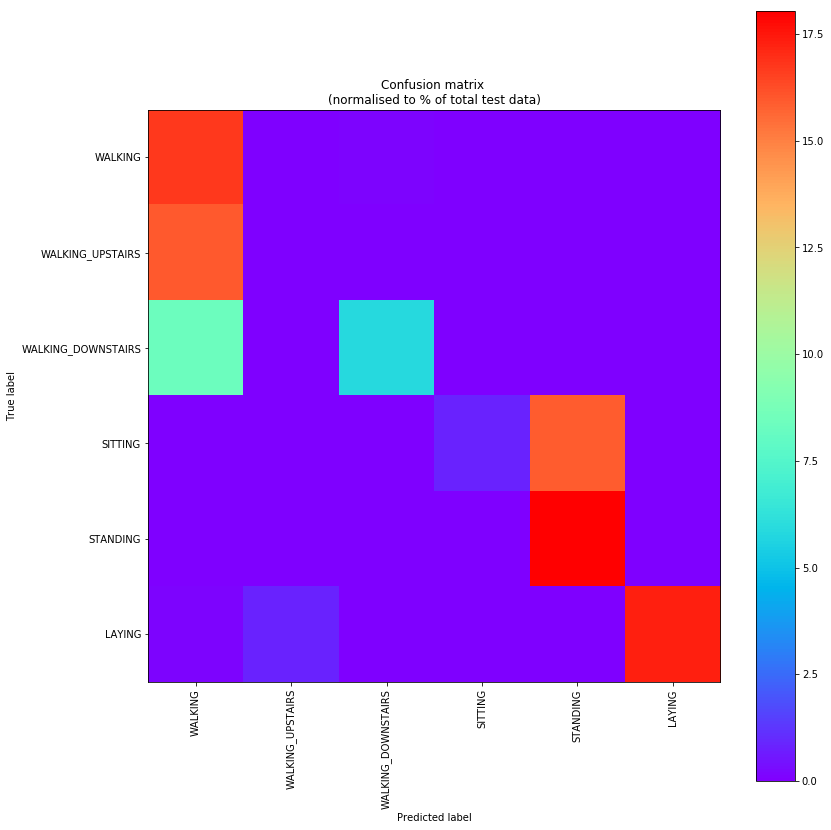

-------------SVM(OVO)-------------
Training time is: 189.22538781166077 seconds
FINAL SCORE FOR SVM OVR:
0.5873769935527655

Precision: 65.33044800918265%
Recall: 58.737699355276554%
f1_score: 49.75906649475647%

Confusion Matrix:
[[493   0   3   0   0   0]
 [471   0   0   0   0   0]
 [247   0 173   0   0   0]
 [  0   0   0  23 468   0]
 [  0   0   0   0 532   0]
 [  3  24   0   0   0 510]]

Confusion matrix (normalised to % of total test data):
[[16.728876    0.          0.10179844  0.          0.          0.        ]
 [15.982355    0.          0.          0.          0.          0.        ]
 [ 8.381405    0.          5.8703766   0.          0.          0.        ]
 [ 0.          0.          0.          0.7804547  15.880556    0.        ]
 [ 0.          0.          0.          0.         18.052256    0.        ]
 [ 0.10179844  0.8143875   0.          0.          0.         17.305735  ]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that m

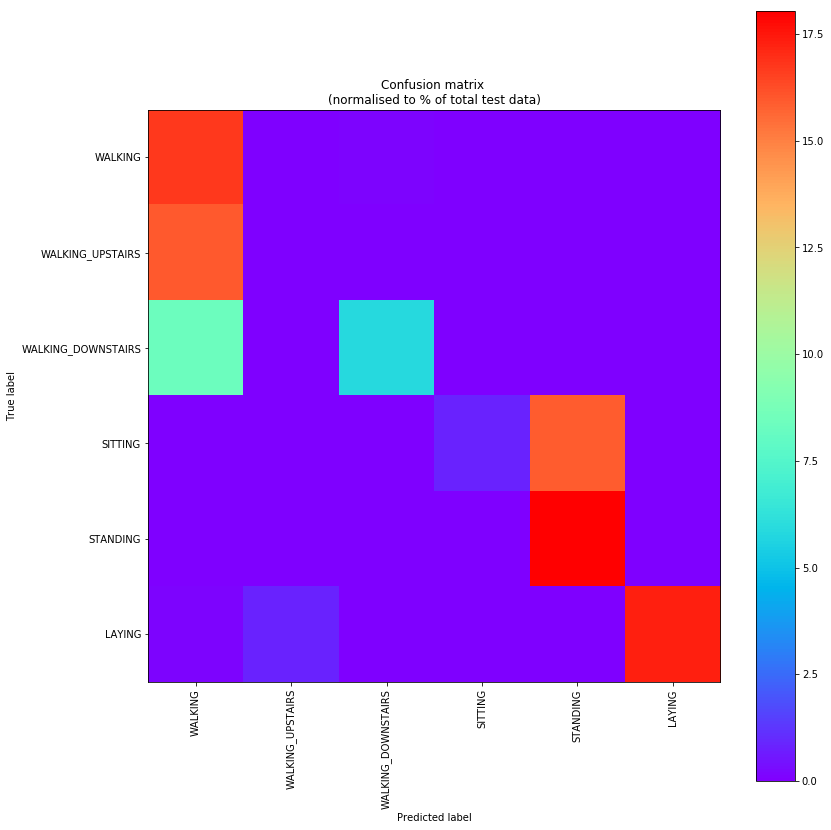

-------------lstm-----------------
(?, 32)
Training iter #1500:   Batch Loss = 1.979642, Accuracy = 0.1653333306312561
PERFORMANCE ON TEST SET: Batch Loss = 1.8602725267410278, Accuracy = 0.18221920728683472
Training iter #300000:   Batch Loss = 0.159613, Accuracy = 0.9559999704360962
PERFORMANCE ON TEST SET: Batch Loss = 0.1847238838672638, Accuracy = 0.935188353061676
Training iter #600000:   Batch Loss = 0.090398, Accuracy = 0.9739999771118164
PERFORMANCE ON TEST SET: Batch Loss = 0.1605163961648941, Accuracy = 0.9467254877090454
Training iter #900000:   Batch Loss = 0.046877, Accuracy = 0.9860000014305115
PERFORMANCE ON TEST SET: Batch Loss = 0.14072047173976898, Accuracy = 0.9531727433204651
Optimization Finished!
Training time is: 763.8484580516815 seconds
FINAL LSTM RESULT: Batch Loss = 0.1496160626411438, Accuracy = 0.9538514018058777
Testing Accuracy: 95.38514018058777%

Precision: 95.5310242638082%
Recall: 95.38513742789277%
f1_score: 95.38797023936841%

Confusion Matrix:
[[4

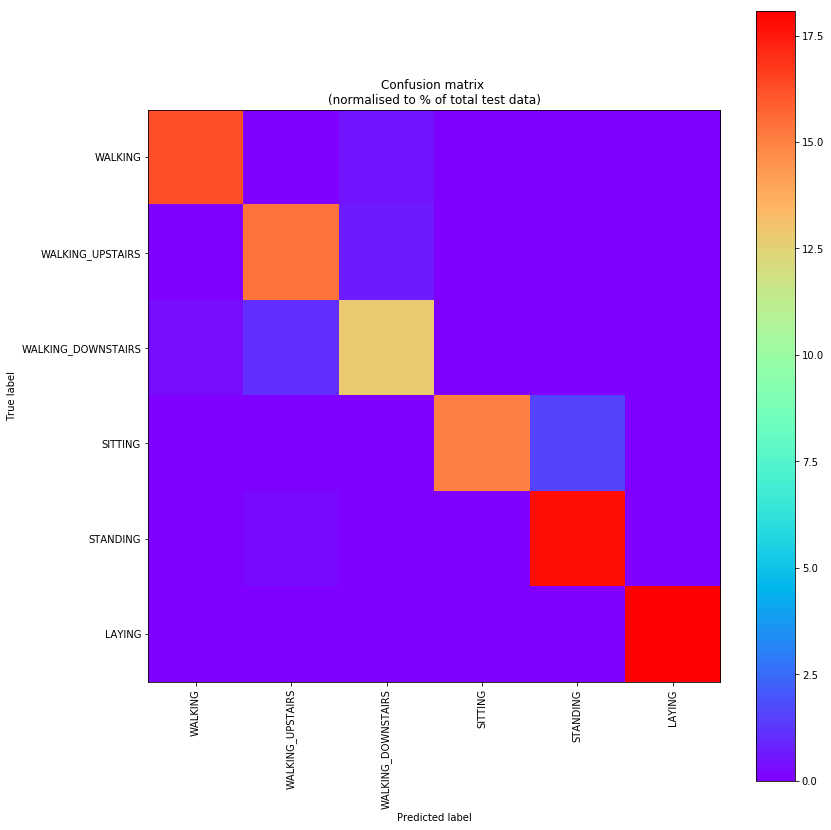

In [2]:
# Experiment 1 (CNN as feature extractor) of feature extractor training with the CNN model model 2.
# CNN model is used as a feature extrator, SVM (ovo or ovr) and a single layer of LSTM is used as personlized classifier
# The personlized classifier is trained with 100% dataset
# The structure based on Guillaume Chevalier https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition
# The structure include read in of the input, formatting the input and the conversion of the one-hot encoding.
# The SVM is model is from sklearn library
# The CNN model and the feature extration method is written by myself
# The credit of this code goes to Guillaume Chevalier under MIT License.
# Python version 3.6

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import time
import os

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 

# Pathes to dataset
DATASET_PATH = "UCI HAR Dataset/"
TRAIN = "train/"
TEST = "test/"


def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]
y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

X_for_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
y_for_train = load_y(y_train_path)
y_test = load_y(y_test_path)

print("read in the data")

# randomly shuffle the array
def rand_shuffle_data(train_X, train_Y):
    item_size = np.array(train_X).shape
    sample_size = item_size[0]
    np.random.seed(42)
    value_list = np.arange(sample_size)
    np.random.shuffle(value_list)
    output_X = np.zeros(np.array(train_X).shape)
    output_Y = np.zeros(np.array(train_Y).shape)
    print(output_Y.shape)
    cnt = 0
    for idx in value_list:
        output_X[cnt,:,:] = train_X[idx,:,:]
        output_Y[cnt,:] = train_Y[idx,:]
        cnt += 1
    return value_list, output_X, output_Y

# The pre-trained model
def cnn_net(_X):
    _X = tf.reshape(_X, [-1, n_steps, n_input]) 
    # convlution layers
    conv1 = tf.layers.separable_conv1d(_X, 32, 5, activation=tf.nn.relu, name='conv1_layer') 
    conv1 = tf.layers.max_pooling1d(conv1, 20, 2, name='max1_layer')
    conv2 = tf.layers.separable_conv1d(conv1, 64, 5, activation=tf.nn.relu, name='conv2_layer')
    fc1 = tf.contrib.layers.flatten(conv2)
    fc1 = tf.layers.dense(fc1, 1024)
    out = tf.layers.dense(fc1, n_classes)
    return out

# The personalized classifier
def lstm_net(_X, _weights, _biases):
    conv2 = tf.transpose(_X, [1, 0, 2])
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.nn.dynamic_rnn(lstm_cells, conv2, dtype=tf.float32)
    lstm_last_output = outputs[-1]
    # Linear activation
    print(lstm_last_output.shape)
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']

def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS


percentage_list = [1]

for percent_train in percentage_list:
    
    tf.reset_default_graph() # reset my graph
    
    rand_shuffle_idx, train_X, train_y = rand_shuffle_data(X_for_train, y_for_train)
    pick_samples = int(round((np.array(X_for_train).shape[0])*percent_train))
    X_train = X_for_train[0:pick_samples, :, :]
    y_train = y_for_train[0:pick_samples,:]
    
    print(np.array(X_train).shape)
    
    # Input data and LSTM internal structure
    training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
    test_data_count = len(X_test)  # 2947 testing series
    n_height = 1
    n_steps = len(X_train[0])  # 128 timesteps per series
    n_input = len(X_train[0][0])
    n_hidden = 32
    n_classes = 6 # Total classes (should go up, or should go down)

    # Training parameters
    learning_rate = 0.0001
    lambda_loss_amount = 0.0015
    training_iters = training_data_count * 250  # Loop 300 times on the dataset
    batch_size = 1500
    display_iter = 300000  # To show test set accuracy during training
    
    # Graph input/output
    x = tf.placeholder(tf.float32, [None, n_steps, n_input])
    y = tf.placeholder(tf.float32, [None, n_classes])
    
    pred = cnn_net(x)

    # Loss, optimizer and evaluation
    l2 = lambda_loss_amount * sum(
        tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
    ) # L2 loss prevents this overkill neural network to overfit the data
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2# Softmax loss
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # To keep track of training's performance
    test_losses = []
    test_accuracies = []
    train_losses = []
    train_accuracies = []

    # Launch the graph
    print("start training")
    start_time = time.time()
    sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
    init = tf.global_variables_initializer()
    sess.run(init)

    # Perform Training steps with "batch_size" amount of example data at each loop
    step = 1
    while step * batch_size <= training_iters:
        batch_xs =         extract_batch_size(X_train, step, batch_size)
        batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

        # Fit training using batch data
        _, loss, acc = sess.run(
            [optimizer, cost, accuracy],
            feed_dict={
                x: batch_xs, 
                y: batch_ys
            }
        )
        train_losses.append(loss)
        train_accuracies.append(acc)
        
        loss2, acc2 = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss2)
        test_accuracies.append(acc2)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):

            # To not spam console, show training accuracy/loss in this "if"
            print("Training iter #" + str(step*batch_size) + \
                  ":   Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))

            # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
            print("PERFORMANCE ON TEST SET: " + \
                  "Batch Loss = {}".format(loss2) + \
                  ", Accuracy = {}".format(acc2))

        step += 1

    print("Optimization Finished!")
    print("Training time is: " + str(time.time() - start_time) + " seconds")
    # Accuracy for test data

    one_hot_predictions, accuracy, final_loss = sess.run(
        [pred, accuracy, cost],
        feed_dict={
            x: X_test,
            y: one_hot(y_test)
        }
    )

    print("FINAL CNN RESULT: " + \
          "Batch Loss = {}".format(final_loss) + \
          ", Accuracy = {}".format(accuracy))

    
    
    # extract the features
    feature_tensor = sess.graph.get_tensor_by_name('conv2_layer/Relu:0')
    features = sess.run(feature_tensor, feed_dict={x:X_train})
    feature_shape = features.shape
    test_features = sess.run(feature_tensor,feed_dict={x:X_test})
    test_feature_shape = test_features.shape
    reformatted_features = np.zeros((feature_shape[0], feature_shape[1]*feature_shape[2]))
    test_reformatted_features = np.zeros((test_feature_shape[0], test_feature_shape[1]*test_feature_shape[2]))
    c = 0
    for row in features:
        reformatted_features[c,:] = row.flatten()
        c += 1
    d = 0
    for row in test_features:
        test_reformatted_features[d,:] = row.flatten()
        d += 1
        
    # classify with svm
    from sklearn.svm import SVC
    svm_starttime = time.time()
    clf = SVC()
    clf.fit(reformatted_features, y_train)
    print("-------------SVM(OVR)-------------")
    print("Training time is: " + str(time.time() - svm_starttime) + " seconds")
    print("FINAL SCORE FOR SVM OVR:")
    print(clf.score(test_reformatted_features, y_test))
    
    svm_pred_1 = clf.predict(test_reformatted_features)
    
    print("")
    print("Precision: {}%".format(100*metrics.precision_score(y_test, svm_pred_1, average="weighted")))
    print("Recall: {}%".format(100*metrics.recall_score(y_test, svm_pred_1, average="weighted")))
    print("f1_score: {}%".format(100*metrics.f1_score(y_test, svm_pred_1, average="weighted")))
    
    print("")
    print("Confusion Matrix:")
    confusion_matrix = metrics.confusion_matrix(y_test, svm_pred_1)
    print(confusion_matrix)
    normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

    print("")
    print("Confusion matrix (normalised to % of total test data):")
    print(normalised_confusion_matrix)
    print("Note: training and testing data is not equally distributed amongst classes, ")
    print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")
    
    # Plot Results: 
    width = 12
    height = 12
    f = plt.figure(figsize=(width, height))
    plt.imshow(
        normalised_confusion_matrix, 
        interpolation='nearest', 
        cmap=plt.cm.rainbow
    )
    plt.title("Confusion matrix \n(normalised to % of total test data)")
    plt.colorbar()
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, LABELS, rotation=90)
    plt.yticks(tick_marks, LABELS)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    f.savefig("cnn_svm_ovr_conf.pdf", bbox_inches='tight')
    f.savefig("cnn_svm_ovr_conf.png", bbox_inches='tight')
    
    
    svm2_starttime = time.time()
    clf2 = SVC(decision_function_shape='ovo')
    clf2.fit(reformatted_features, y_train)
    print("-------------SVM(OVO)-------------")
    print("Training time is: " + str(time.time() - svm2_starttime) + " seconds")
    print("FINAL SCORE FOR SVM OVR:")
    print(clf2.score(test_reformatted_features, y_test))
    
    svm_pred_2 = clf2.predict(test_reformatted_features)
    
    print("")
    print("Precision: {}%".format(100*metrics.precision_score(y_test, svm_pred_2, average="weighted")))
    print("Recall: {}%".format(100*metrics.recall_score(y_test, svm_pred_2, average="weighted")))
    print("f1_score: {}%".format(100*metrics.f1_score(y_test, svm_pred_2, average="weighted")))
    
    print("")
    print("Confusion Matrix:")
    confusion_matrix = metrics.confusion_matrix(y_test, svm_pred_2)
    print(confusion_matrix)
    normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

    print("")
    print("Confusion matrix (normalised to % of total test data):")
    print(normalised_confusion_matrix)
    print("Note: training and testing data is not equally distributed amongst classes, ")
    print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")
    
     # Plot Results: 
    width = 12
    height = 12
    f = plt.figure(figsize=(width, height))
    plt.imshow(
        normalised_confusion_matrix, 
        interpolation='nearest', 
        cmap=plt.cm.rainbow
    )
    plt.title("Confusion matrix \n(normalised to % of total test data)")
    plt.colorbar()
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, LABELS, rotation=90)
    plt.yticks(tick_marks, LABELS)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    f.savefig("cnn_svm_ovo_conf.pdf", bbox_inches='tight')
    f.savefig("cnn_svm_ovo_conf.png", bbox_inches='tight')
    
    start_time_lstm = time.time()
    print("-------------lstm-----------------")
    tf.reset_default_graph() # reset my graph
    
    weights = {
        'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([n_classes]))
    }
    
    learning_rate_lstm = 0.0025
    
    x_feat = tf.placeholder(tf.float32, [None, feature_shape[1], feature_shape[2]])
    y2 = tf.placeholder(tf.float32, [None, n_classes])
    pred_lstm = lstm_net(x_feat, weights, biases)
    cost2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y2, logits=pred_lstm))# Softmax loss
    optimizer2 = tf.train.AdamOptimizer(learning_rate=learning_rate_lstm).minimize(cost2)
    correct_pred2 = tf.equal(tf.argmax(pred_lstm,1), tf.argmax(y2,1))
    accuracy2 = tf.reduce_mean(tf.cast(correct_pred2, tf.float32))
    
    test_losses2 = []
    test_accuracies2 = []
    train_losses2 = []
    train_accuracies2 = []
    training_iters2 = training_data_count * 150  # Loop 300 times on the dataset
    
    sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
    init = tf.global_variables_initializer()
    sess.run(init)
    
    step = 1
    while step * batch_size <= training_iters2:
        batch_xxs =         extract_batch_size(features, step, batch_size)
        batch_yys = one_hot(extract_batch_size(y_train, step, batch_size))

        # Fit training using batch data
        _, loss, acc = sess.run(
            [optimizer2, cost2, accuracy2],
            feed_dict={
                x_feat: batch_xxs, 
                y2: batch_yys
            }
        )
        train_losses2.append(loss)
        train_accuracies2.append(acc)
        
        loss2, acc2 = sess.run(
            [cost2, accuracy2], 
            feed_dict={
                x_feat: test_features,
                y2: one_hot(y_test)
            }
        )
        test_losses2.append(loss2)
        test_accuracies2.append(acc2)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters2):

            # To not spam console, show training accuracy/loss in this "if"
            print("Training iter #" + str(step*batch_size) + \
                  ":   Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))

            # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
            print("PERFORMANCE ON TEST SET: " + \
                  "Batch Loss = {}".format(loss2) + \
                  ", Accuracy = {}".format(acc2))

        step += 1

    print("Optimization Finished!")
    print("Training time is: " + str(time.time() - start_time_lstm) + " seconds")

    one_hot_predictions2, accuracy2, final_loss2 = sess.run(
        [pred_lstm, accuracy2, cost2],
        feed_dict={
            x_feat: test_features,
            y2: one_hot(y_test)
        }
    )

    print("FINAL LSTM RESULT: " + \
          "Batch Loss = {}".format(final_loss2) + \
          ", Accuracy = {}".format(accuracy2))
    
    predictions2 = one_hot_predictions2.argmax(1)
    
    print("Testing Accuracy: {}%".format(100*accuracy2))

    print("")
    print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions2, average="weighted")))
    print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions2, average="weighted")))
    print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions2, average="weighted")))
    
    print("")
    print("Confusion Matrix:")
    confusion_matrix = metrics.confusion_matrix(y_test, predictions2)
    print(confusion_matrix)
    normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

    print("")
    print("Confusion matrix (normalised to % of total test data):")
    print(normalised_confusion_matrix)
    print("Note: training and testing data is not equally distributed amongst classes, ")
    print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")
    
    # Plot Results: 
    width = 12
    height = 12
    f = plt.figure(figsize=(width, height))
    plt.imshow(
        normalised_confusion_matrix, 
        interpolation='nearest', 
        cmap=plt.cm.rainbow
    )
    plt.title("Confusion matrix \n(normalised to % of total test data)")
    plt.colorbar()
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, LABELS, rotation=90)
    plt.yticks(tick_marks, LABELS)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    f.savefig("cnn_feat_lstm_train_conf.pdf", bbox_inches='tight')
    f.savefig("cnn_feat_lstm_train_conf.png", bbox_inches='tight')

In [1]:
# Experiment 1 (CNN as feature extractor) of feature extractor training with the CNN model model 2.
# CNN model is used as a feature extrator, SVM (ovo or ovr) and a single layer of LSTM is used as personlized classifier
# The personlized classifier is trained with 50% dataset
# The structure based on Guillaume Chevalier https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition
# The structure include read in of the input, formatting the input and the conversion of the one-hot encoding.
# The SVM is model is from sklearn library
# The CNN model and the feature extration method is written by myself
# The credit of this code goes to Guillaume Chevalier under MIT License.
# Python version 3.6

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
from sklearn import metrics
import time
import os

# Those are separate normalised input features for the neural network
INPUT_SIGNAL_TYPES = [
    "body_acc_x_",
    "body_acc_y_",
    "body_acc_z_",
    "body_gyro_x_",
    "body_gyro_y_",
    "body_gyro_z_",
    "total_acc_x_",
    "total_acc_y_",
    "total_acc_z_"
]

# Output classes to learn how to classify
LABELS = [
    "WALKING", 
    "WALKING_UPSTAIRS", 
    "WALKING_DOWNSTAIRS", 
    "SITTING", 
    "STANDING", 
    "LAYING"
] 

# Pathes to dataset
DATASET_PATH = "UCI HAR Dataset/"
TRAIN = "train/"
TEST = "test/"


def load_X(X_signals_paths):
    X_signals = []
    
    for signal_type_path in X_signals_paths:
        file = open(signal_type_path, 'r')
        # Read dataset from disk, dealing with text files' syntax
        X_signals.append(
            [np.array(serie, dtype=np.float32) for serie in [
                row.replace('  ', ' ').strip().split(' ') for row in file
            ]]
        )
        file.close()
    
    return np.transpose(np.array(X_signals), (1, 2, 0))

def load_y(y_path):
    file = open(y_path, 'r')
    # Read dataset from disk, dealing with text file's syntax
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # Substract 1 to each output class for friendly 0-based indexing 
    return y_ - 1

X_train_signals_paths = [
    DATASET_PATH + TRAIN + "Inertial Signals/" + signal + "train.txt" for signal in INPUT_SIGNAL_TYPES
]
X_test_signals_paths = [
    DATASET_PATH + TEST + "Inertial Signals/" + signal + "test.txt" for signal in INPUT_SIGNAL_TYPES
]
y_train_path = DATASET_PATH + TRAIN + "y_train.txt"
y_test_path = DATASET_PATH + TEST + "y_test.txt"

X_for_train = load_X(X_train_signals_paths)
X_test = load_X(X_test_signals_paths)
y_for_train = load_y(y_train_path)
y_test = load_y(y_test_path)

print("read in the data")

# randomly shuffle the array
def rand_shuffle_data(train_X, train_Y):
    item_size = np.array(train_X).shape
    sample_size = item_size[0]
    np.random.seed(42)
    value_list = np.arange(sample_size)
    np.random.shuffle(value_list)
    output_X = np.zeros(np.array(train_X).shape)
    output_Y = np.zeros(np.array(train_Y).shape)
    print(output_Y.shape)
    cnt = 0
    for idx in value_list:
        output_X[cnt,:,:] = train_X[idx,:,:]
        output_Y[cnt,:] = train_Y[idx,:]
        cnt += 1
    return value_list, output_X, output_Y

# The pre-trained model
def cnn_net(_X):
    _X = tf.reshape(_X, [-1, n_steps, n_input]) 
    # convlution layers
    conv1 = tf.layers.separable_conv1d(_X, 32, 5, activation=tf.nn.relu, name='conv1_layer') 
    conv1 = tf.layers.max_pooling1d(conv1, 20, 2, name='max1_layer')
    conv2 = tf.layers.separable_conv1d(conv1, 64, 5, activation=tf.nn.relu, name='conv2_layer')
    fc1 = tf.contrib.layers.flatten(conv2)
    fc1 = tf.layers.dense(fc1, 1024)
    out = tf.layers.dense(fc1, n_classes)
    return out

# The personalized classifier
def lstm_net(_X, _weights, _biases):
    conv2 = tf.transpose(_X, [1, 0, 2])
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.contrib.rnn.MultiRNNCell([lstm_cell], state_is_tuple=True)
    # Get LSTM cell output
    outputs, states = tf.nn.dynamic_rnn(lstm_cells, conv2, dtype=tf.float32)
    lstm_last_output = outputs[-1]
    # Linear activation
    print(lstm_last_output.shape)
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']

def extract_batch_size(_train, step, batch_size):
    # Function to fetch a "batch_size" amount of data from "(X|y)_train" data. 
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)

    for i in range(batch_size):
        # Loop index
        index = ((step-1)*batch_size + i) % len(_train)
        batch_s[i] = _train[index] 

    return batch_s


def one_hot(y_):
    # Function to encode output labels from number indexes 
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS


percentage_list = [1]

for percent_train in percentage_list:
    
    tf.reset_default_graph() # reset my graph
    
    rand_shuffle_idx, train_X, train_y = rand_shuffle_data(X_for_train, y_for_train)
    pick_samples = int(round((np.array(X_for_train).shape[0])*percent_train))
    X_train = X_for_train[0:pick_samples, :, :]
    y_train = y_for_train[0:pick_samples,:]
    
    print(np.array(X_train).shape)
    
    # Input data and LSTM internal structure
    training_data_count = len(X_train)  # 7352 training series (with 50% overlap between each serie)
    test_data_count = len(X_test)  # 2947 testing series
    n_height = 1
    n_steps = len(X_train[0])  # 128 timesteps per series
    n_input = len(X_train[0][0])
    n_hidden = 32
    n_classes = 6 # Total classes (should go up, or should go down)

    # Training parameters
    learning_rate = 0.0001
    lambda_loss_amount = 0.0015
    training_iters = training_data_count * 250  # Loop 300 times on the dataset
    batch_size = 1500
    display_iter = 300000  # To show test set accuracy during training
    
    # Graph input/output
    x = tf.placeholder(tf.float32, [None, n_steps, n_input])
    y = tf.placeholder(tf.float32, [None, n_classes])
    
    pred = cnn_net(x)

    # Loss, optimizer and evaluation
    l2 = lambda_loss_amount * sum(
        tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables()
    ) # L2 loss prevents this overkill neural network to overfit the data
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2# Softmax loss
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost) # Adam Optimizer

    correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

    # To keep track of training's performance
    test_losses = []
    test_accuracies = []
    train_losses = []
    train_accuracies = []

    # Launch the graph
    print("start training")
    start_time = time.time()
    sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
    init = tf.global_variables_initializer()
    sess.run(init)

    # Perform Training steps with "batch_size" amount of example data at each loop
    step = 1
    while step * batch_size <= training_iters:
        batch_xs =         extract_batch_size(X_train, step, batch_size)
        batch_ys = one_hot(extract_batch_size(y_train, step, batch_size))

        # Fit training using batch data
        _, loss, acc = sess.run(
            [optimizer, cost, accuracy],
            feed_dict={
                x: batch_xs, 
                y: batch_ys
            }
        )
        train_losses.append(loss)
        train_accuracies.append(acc)
        
        loss2, acc2 = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss2)
        test_accuracies.append(acc2)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):

            # To not spam console, show training accuracy/loss in this "if"
            print("Training iter #" + str(step*batch_size) + \
                  ":   Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))

            # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
            print("PERFORMANCE ON TEST SET: " + \
                  "Batch Loss = {}".format(loss2) + \
                  ", Accuracy = {}".format(acc2))

        step += 1

    print("Optimization Finished!")
    print("Training time is: " + str(time.time() - start_time) + " seconds")
    # Accuracy for test data

    one_hot_predictions, accuracy, final_loss = sess.run(
        [pred, accuracy, cost],
        feed_dict={
            x: X_test,
            y: one_hot(y_test)
        }
    )

    print("FINAL CNN RESULT: " + \
          "Batch Loss = {}".format(final_loss) + \
          ", Accuracy = {}".format(accuracy))

    pick_samples_1 = int(round((np.array(X_for_train).shape[0])*0.5))
    X_train_1 = X_for_train[0:pick_samples_1, :, :]
    y_train_1 = y_for_train[0:pick_samples_1,:]
    
    # extract the features
    feature_tensor = sess.graph.get_tensor_by_name('conv2_layer/Relu:0')
    features = sess.run(feature_tensor, feed_dict={x:X_train_1})
    feature_shape = features.shape
    test_features = sess.run(feature_tensor,feed_dict={x:X_test})
    test_feature_shape = test_features.shape
    reformatted_features = np.zeros((feature_shape[0], feature_shape[1]*feature_shape[2]))
    test_reformatted_features = np.zeros((test_feature_shape[0], test_feature_shape[1]*test_feature_shape[2]))
    c = 0
    for row in features:
        reformatted_features[c,:] = row.flatten()
        c += 1
    d = 0
    for row in test_features:
        test_reformatted_features[d,:] = row.flatten()
        d += 1
        
    # classify with svm
    from sklearn.svm import SVC
    svm_starttime = time.time()
    clf = SVC()
    clf.fit(reformatted_features, y_train_1)
    print("-------------SVM(OVR)-------------")
    print("Training time is: " + str(time.time() - svm_starttime) + " seconds")
    print("FINAL SCORE FOR SVM OVR:")
    print(clf.score(test_reformatted_features, y_test))
    
    svm_pred_1 = clf.predict(test_reformatted_features)
    
    print("")
    print("Precision: {}%".format(100*metrics.precision_score(y_test, svm_pred_1, average="weighted")))
    print("Recall: {}%".format(100*metrics.recall_score(y_test, svm_pred_1, average="weighted")))
    print("f1_score: {}%".format(100*metrics.f1_score(y_test, svm_pred_1, average="weighted")))
    
    print("")
    print("Confusion Matrix:")
    confusion_matrix = metrics.confusion_matrix(y_test, svm_pred_1)
    print(confusion_matrix)
    normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

    print("")
    print("Confusion matrix (normalised to % of total test data):")
    print(normalised_confusion_matrix)
    print("Note: training and testing data is not equally distributed amongst classes, ")
    print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")
    
    # Plot Results: 
    width = 12
    height = 12
    f = plt.figure(figsize=(width, height))
    plt.imshow(
        normalised_confusion_matrix, 
        interpolation='nearest', 
        cmap=plt.cm.rainbow
    )
    plt.title("Confusion matrix \n(normalised to % of total test data)")
    plt.colorbar()
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, LABELS, rotation=90)
    plt.yticks(tick_marks, LABELS)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    f.savefig("cnn_svm_ovr_conf1.pdf", bbox_inches='tight')
    f.savefig("cnn_svm_ovr_conf1.png", bbox_inches='tight')
    
    
    svm2_starttime = time.time()
    clf2 = SVC(decision_function_shape='ovo')
    clf2.fit(reformatted_features, y_train_1)
    print("-------------SVM(OVO)-------------")
    print("Training time is: " + str(time.time() - svm2_starttime) + " seconds")
    print("FINAL SCORE FOR SVM OVR:")
    print(clf2.score(test_reformatted_features, y_test))
    
    svm_pred_2 = clf2.predict(test_reformatted_features)
    
    print("")
    print("Precision: {}%".format(100*metrics.precision_score(y_test, svm_pred_2, average="weighted")))
    print("Recall: {}%".format(100*metrics.recall_score(y_test, svm_pred_2, average="weighted")))
    print("f1_score: {}%".format(100*metrics.f1_score(y_test, svm_pred_2, average="weighted")))
    
    print("")
    print("Confusion Matrix:")
    confusion_matrix = metrics.confusion_matrix(y_test, svm_pred_2)
    print(confusion_matrix)
    normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

    print("")
    print("Confusion matrix (normalised to % of total test data):")
    print(normalised_confusion_matrix)
    print("Note: training and testing data is not equally distributed amongst classes, ")
    print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")
    
     # Plot Results: 
    width = 12
    height = 12
    f = plt.figure(figsize=(width, height))
    plt.imshow(
        normalised_confusion_matrix, 
        interpolation='nearest', 
        cmap=plt.cm.rainbow
    )
    plt.title("Confusion matrix \n(normalised to % of total test data)")
    plt.colorbar()
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, LABELS, rotation=90)
    plt.yticks(tick_marks, LABELS)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    f.savefig("cnn_svm_ovo_conf1.pdf", bbox_inches='tight')
    f.savefig("cnn_svm_ovo_conf1.png", bbox_inches='tight')
    
    start_time_lstm = time.time()
    print("-------------lstm-----------------")
    tf.reset_default_graph() # reset my graph
    
    weights = {
        'out': tf.Variable(tf.random_normal([n_hidden, n_classes], mean=1.0))
    }
    biases = {
        'out': tf.Variable(tf.random_normal([n_classes]))
    }
    
    learning_rate_lstm = 0.0025
    
    x_feat = tf.placeholder(tf.float32, [None, feature_shape[1], feature_shape[2]])
    y2 = tf.placeholder(tf.float32, [None, n_classes])
    pred_lstm = lstm_net(x_feat, weights, biases)
    cost2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y2, logits=pred_lstm))# Softmax loss
    optimizer2 = tf.train.AdamOptimizer(learning_rate=learning_rate_lstm).minimize(cost2)
    correct_pred2 = tf.equal(tf.argmax(pred_lstm,1), tf.argmax(y2,1))
    accuracy2 = tf.reduce_mean(tf.cast(correct_pred2, tf.float32))
    
    test_losses2 = []
    test_accuracies2 = []
    train_losses2 = []
    train_accuracies2 = []
    training_iters2 = training_data_count * 150  # Loop 300 times on the dataset
    
    sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
    init = tf.global_variables_initializer()
    sess.run(init)
    
    step = 1
    while step * batch_size <= training_iters2:
        batch_xxs =         extract_batch_size(features, step, batch_size)
        batch_yys = one_hot(extract_batch_size(y_train_1, step, batch_size))

        # Fit training using batch data
        _, loss, acc = sess.run(
            [optimizer2, cost2, accuracy2],
            feed_dict={
                x_feat: batch_xxs, 
                y2: batch_yys
            }
        )
        train_losses2.append(loss)
        train_accuracies2.append(acc)
        
        loss2, acc2 = sess.run(
            [cost2, accuracy2], 
            feed_dict={
                x_feat: test_features,
                y2: one_hot(y_test)
            }
        )
        test_losses2.append(loss2)
        test_accuracies2.append(acc2)

        # Evaluate network only at some steps for faster training: 
        if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters2):

            # To not spam console, show training accuracy/loss in this "if"
            print("Training iter #" + str(step*batch_size) + \
                  ":   Batch Loss = " + "{:.6f}".format(loss) + \
                  ", Accuracy = {}".format(acc))

            # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
            print("PERFORMANCE ON TEST SET: " + \
                  "Batch Loss = {}".format(loss2) + \
                  ", Accuracy = {}".format(acc2))

        step += 1

    print("Optimization Finished!")
    print("Training time is: " + str(time.time() - start_time_lstm) + " seconds")

    one_hot_predictions2, accuracy2, final_loss2 = sess.run(
        [pred_lstm, accuracy2, cost2],
        feed_dict={
            x_feat: test_features,
            y2: one_hot(y_test)
        }
    )

    print("FINAL LSTM RESULT: " + \
          "Batch Loss = {}".format(final_loss2) + \
          ", Accuracy = {}".format(accuracy2))
    
    predictions2 = one_hot_predictions2.argmax(1)
    
    print("Testing Accuracy: {}%".format(100*accuracy2))

    print("")
    print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions2, average="weighted")))
    print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions2, average="weighted")))
    print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions2, average="weighted")))
    
    print("")
    print("Confusion Matrix:")
    confusion_matrix = metrics.confusion_matrix(y_test, predictions2)
    print(confusion_matrix)
    normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100

    print("")
    print("Confusion matrix (normalised to % of total test data):")
    print(normalised_confusion_matrix)
    print("Note: training and testing data is not equally distributed amongst classes, ")
    print("so it is normal that more than a 6th of the data is correctly classifier in the last category.")
    
    # Plot Results: 
    width = 12
    height = 12
    f = plt.figure(figsize=(width, height))
    plt.imshow(
        normalised_confusion_matrix, 
        interpolation='nearest', 
        cmap=plt.cm.rainbow
    )
    plt.title("Confusion matrix \n(normalised to % of total test data)")
    plt.colorbar()
    tick_marks = np.arange(n_classes)
    plt.xticks(tick_marks, LABELS, rotation=90)
    plt.yticks(tick_marks, LABELS)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    f.savefig("cnn_feat_lstm_train_conf1.pdf", bbox_inches='tight')
    f.savefig("cnn_feat_lstm_train_conf1.png", bbox_inches='tight')

read in the data
(7352, 1)
(7352, 128, 9)
Instructions for updating:
Use the retry module or similar alternatives.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

start training
Training iter #1500:   Batch Loss = 3.012986, Accuracy = 0.4339999854564667
PERFORMANCE ON TEST SET: Batch Loss = 2.9847655296325684, Accuracy = 0.3885307013988495
Training iter #300000:   Batch Loss = 0.860838, Accuracy = 0.9453333616256714
PERFORMANCE ON TEST SET: Batch Loss = 1.038323163986206, Accuracy = 0.8439090847969055
Training iter #600000:   Batch Loss = 0.569806, Accuracy = 0.8679999709129333
PERFORMANCE ON TEST SET: Batch Loss = 0.6699758172035217, Accuracy = 0.8717339634895325
Training iter #900000:   Batch Loss = 0.345212, Accuracy = 0.9546666741371155
PERFORMANCE ON TEST SET: Batch Loss = 0.5313519239425659, Accuracy = 0.8832710981369019
Training iter #12000

c:\users\edwar\anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


-------------SVM(OVR)-------------
Training time is: 56.123528718948364 seconds
FINAL SCORE FOR SVM OVR:
0.5232439769256871

Precision: 80.21921607477537%
Recall: 52.324397692568716%
f1_score: 39.2259574098903%

Confusion Matrix:
[[496   0   0   0   0   0]
 [455   4   0   0  12   0]
 [417   0   3   0   0   0]
 [  0   0   0   1 490   0]
 [  4   0   0   0 528   0]
 [  0   0   0   0  27 510]]

Confusion matrix (normalised to % of total test data):
[[16.830675    0.          0.          0.          0.          0.        ]
 [15.43943     0.13573125  0.          0.          0.40719375  0.        ]
 [14.149983    0.          0.10179844  0.          0.          0.        ]
 [ 0.          0.          0.          0.03393281 16.627077    0.        ]
 [ 0.13573125  0.          0.          0.         17.916527    0.        ]
 [ 0.          0.          0.          0.          0.916186   17.305735  ]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that mo

<Figure size 1200x1200 with 2 Axes>

-------------SVM(OVO)-------------
Training time is: 55.77107119560242 seconds
FINAL SCORE FOR SVM OVR:
0.5232439769256871

Precision: 80.21921607477537%
Recall: 52.324397692568716%
f1_score: 39.2259574098903%

Confusion Matrix:
[[496   0   0   0   0   0]
 [455   4   0   0  12   0]
 [417   0   3   0   0   0]
 [  0   0   0   1 490   0]
 [  4   0   0   0 528   0]
 [  0   0   0   0  27 510]]

Confusion matrix (normalised to % of total test data):
[[16.830675    0.          0.          0.          0.          0.        ]
 [15.43943     0.13573125  0.          0.          0.40719375  0.        ]
 [14.149983    0.          0.10179844  0.          0.          0.        ]
 [ 0.          0.          0.          0.03393281 16.627077    0.        ]
 [ 0.13573125  0.          0.          0.         17.916527    0.        ]
 [ 0.          0.          0.          0.          0.916186   17.305735  ]]
Note: training and testing data is not equally distributed amongst classes, 
so it is normal that mor

<Figure size 1200x1200 with 2 Axes>

-------------lstm-----------------
(?, 32)
Training iter #1500:   Batch Loss = 2.305381, Accuracy = 0.15733332931995392
PERFORMANCE ON TEST SET: Batch Loss = 2.1666078567504883, Accuracy = 0.15982355177402496
Training iter #300000:   Batch Loss = 0.113284, Accuracy = 0.9639999866485596
PERFORMANCE ON TEST SET: Batch Loss = 0.20133183896541595, Accuracy = 0.9297590851783752
Training iter #600000:   Batch Loss = 0.120129, Accuracy = 0.9626666903495789
PERFORMANCE ON TEST SET: Batch Loss = 0.19851039350032806, Accuracy = 0.9287410974502563
Training iter #900000:   Batch Loss = 0.048739, Accuracy = 0.9879999756813049
PERFORMANCE ON TEST SET: Batch Loss = 0.15200914442539215, Accuracy = 0.9487614631652832
Optimization Finished!
Training time is: 755.5035235881805 seconds
FINAL LSTM RESULT: Batch Loss = 0.14458534121513367, Accuracy = 0.9487614631652832
Testing Accuracy: 94.87614631652832%

Precision: 94.93527471466814%
Recall: 94.87614523243977%
f1_score: 94.89346112601368%

Confusion Matri

<Figure size 1200x1200 with 2 Axes>